# Compare Gradient Descent Variations

This Notebook will explore the differences between traditional Batch Gradient Descent, Stochastic Gradient Descent and Mini-Batch Gradient Descent.

## Background

Gradient Descent is a general purpose algorithm that can be used to find a set of parameter values that **optimise** (i.e. minimise or maximise) some other function that depends on the given parameters. Optimisation is a big part of **Machine Learning (ML)**, and so gradient descent can help here!

A common problem in ML might involve trying to fit a curve to some data. We want our curve to match the data as well as possible and we might know the independent variables our function should depend on. However, even if we do know the independent variables involved (we don't need to, but this won't be covered here) we still need to determine the parameter values associated with them.

#### Example

We might have some data that approximately follows a stright line. We know that a straight line has the general equation $y = mx + c$, and so we just need to figure out values for $m$ and $c$ that best match our data. To do this, we can take an initial guess at these values and then calculate our *predicted* $y$ values based on this guess. These predicted values can then be compared against our measured $y$ values. If, for most of data, our predicted and measured values are far apart, then our guess is probably quite bad and we will want to improve it.

#### Cost Function intro

Gradient Descent allows to improve our guesses in the example above by finding the parameters $\theta$ that minimise the **cost function, $J(\theta)$**. The cost function is a measure of the **mean square error** of our predictions $h(\theta)$ vs the actual data $y$, for $m$ observations. As in the example above, our 'cost' is large when our predicted values are far away from our measured ones.

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \big( h(\theta)^{(i)} - y^{(i)} \big)^2 $$

In the above equation, $\theta$ would be a vector containing our current guesses for $m$ and $c$ for our simple example, while $h(\theta)$ is then $mx + c$.

Often, our data won't follow a nice straight line though e.g. maybe it looks a bit curvy and so our $y$ values might also have an $x^3$ dependence. In these examples, we have more *features* (e.g. our data might depend on $x$, $x^2$, $\sqrt{x}$ etc.)

If we were to scale up from our simple example and add more features, then we can generalise our value of $h(\theta)$ to be $X.\theta$. Here, $X$ will be an $m \times (f+1)$ matrix that contains, for each observation, measured values for the different features $f$ plus a *bias* term. The bias term is simply an extra column of $1$s at the start of the matrix which allows us to account for our constant term $c$ from before.

#### Minimising the Cost Function

Now that we know what our prediction $h(\theta)$ looks like in the general *vectorised* case, we can differentiate our cost function. We differentiate our cost function with respect to our different $\theta_j$ values as these are the parameters that determine the size of $J(\theta)$.

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \big( h(\theta)^{(i)} - y^{(i)} \big).X_j^{(i)} $$

This calculation requires a decent level of background in mathematics to understand and we won't go into the details here. However, you don't need to understand the maths involved to be able to use this result and implement the algorithms in the code below.

#### Optimising our $\theta$ values

Now that we know how our cost function changes with our different parameter values, we can slowly step our way towards values which minimise $J(\theta)$. To do this, we take our current $\theta_j$ values in turn and move to a slightly different $\theta_j$ value in the direction which should cause $J(\theta)$ to decrease. The size of each step is determined by our learning rate $\alpha$. Putting everything together, we end up with the following update formula:

$$\theta_j := \theta_j - \frac{\alpha}{m} \sum_{i=1}^{m} \big( h(\theta)^{(i)} - y^{(i)} \big).X_j^{(i)} $$

The above might look complicated, but all we are doing is starting at our current $\theta_j$ values and taking a small step down the gradient we calculated earlier.

And that's it! If we repeat the above optimisation process for many iterations (making sure our step size isn't too big!) then we should be able to slowly step our way down to the minimum of our cost function $J(\theta)$. Once we've reached the bottom (within a certain tolerance) then our predicted parameters $\theta$ should be very close to the parameters behind the data created.

#### Comparing different Gradient Descent Methods

When updating our cost and gradient at each iteration, we can choose to include all of our data (Batch), some of our data (Mini-Batch) or just 1 observation (Stochastic). Each of these methods has their pros and cons which are highlighed below and become evident after examining the results of our code too.

| Algorithm | Pros | Cons |
| :--- | :--- | :--- |
| Batch | <ul><li>Smooth Updates - will always make progress towards minimum</li></ul> | <ul><li>Each iteration can take a long time if dealing with large datasets</li></ul> |
| Stochastic | <ul><li>Can be quick to converge to an approximate minimum</li><li>Less likely to get stuck in local minima than Batch method</li></ul> | <ul><li>Updates are noisy</li><li>Cannot exploit speed associated with vectorising the code</li></ul> |
| Mini-Batch | <ul><li>Aims to combine the best of aspects of Batch and Stochastic methods</li><li>Cost minimised faster than Batch</li><li>Less noisy than stochastic</li></ul> | <ul><li>Might need to spend more time optimising the step size and batch size to achieve optimal peformance</li></ul> |

## Coding our Gradient Descent Algorithms

#### Import dependencies

In [1]:
import math
import time
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook

## Generate our dummy data

In [2]:
# number of random data points to generate
N = 10000

In [3]:
# generate array of random floats for our independent variable, x (values between 0 and 1 as default)
x = np.random.rand(N)
x = np.array(sorted(x))

In [4]:
# to make this a bit more interesting than a simple linear problem, we will also introduce an x^2 dependency
x2 = np.square(x)

In [5]:
# define our parameter values that will be used to generate our dependent variable values, y
a0, a1, a2 = 3, 2, -5
a_lst = [a0, a1, a2]

In [6]:
# generate our y values based on our x values, our parameters and introduce some noise (we don't want perfect data!)
y = a0 + a1*x + a2*x2 + np.random.normal(0, 0.2, N)

In [7]:
# also allow ourselves to plot our underlying distribution
y_curve = a0 + a1*x + a2*x2

#### Plot our data

<IPython.core.display.Javascript object>


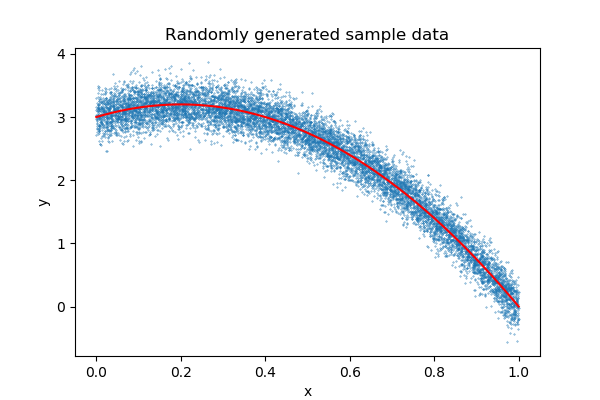

In [8]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Randomly generated sample data')

plt.plot(x, y_curve, color="red")
plt.scatter(x, y, marker='o', s=0.1)

## Create X matrix for use in Gradient Descent

In [9]:
def X_for_gd(*features):
    '''
    Creates X matrix containing all feature values plus bias term for input into cost func and grad desc algos
    
    :param *features: (m, ) ndarrays for all feature values recorded at each observation (m total observations) 
    
    :return: (m, f+1) ndarray
    '''
    # check we have actually passed in some features
    assert len(features) > 0
    
    # initiate X with bias term
    X = np.ones(len(x)).reshape(-1, 1)
    
    for feature in features:
        
        # check all features have the same shape
        assert feature.shape == features[0].shape
        
        # add all feature values to X
        X = np.concatenate((X, feature.reshape(-1, 1)), axis=1)
        
    return X

##### Test our X_for_gd() function

In [10]:
X_for_gd(x, x2).shape

(10000, 3)

## Cost Function

In [11]:
def cost(X, y, theta):
    '''
    Calculates the mean square error (MSE) total cost
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of proposed parameter values for which the cost must be determined
    
    :return: float of MSE cost
    '''
    
    # number of observations made
    m = len(y)
    # our hypothesis i.e. our guess at what y we would obtain given features X and parameters theta
    h = X.dot(theta)
    
    return (1/(2*m)) * np.sum( (h-y)**2 )

In [26]:
def cost_grad(X, y, theta):
    '''
    Calculates the gradient of the cost function w.r.t. to each theta parameter 
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of proposed parameter values for which the cost gradient must be determined
    
    :return: (f+1, ) ndarray of the gradient of the cost function w.r.t. each theta parameter
    ''' 
    
    # number of observations made
    m = len(y)
    # our hypothesis i.e. our guess at what y we would obtain given features X and parameters theta
    h = X.dot(theta)
    
    # for stochastic gd, we will need to change single observed X from an (f+1, ) array to an (f+1, 1) array
    if len(X.shape)==1: X = X.reshape(1, -1)

    return (1/m) * (X.T.dot((h-y)))

##### Test our new functions

In [29]:
X = X_for_gd(x, x2)
theta = np.random.rand(1, X.shape[1])
theta = list(theta[0])

print("MSE cost: {}".format(cost(X, y, theta)))
print("Gradient wrt to each theta parameter: {}".format(cost_grad(X, y, theta)))

MSE cost: 1.4329381707965154
Gradient wrt to each theta parameter: [-1.29149207 -0.35424582 -0.11052263]


## Batch Gradient Descent

In [30]:
def batch_gd(X, y, theta=list(np.random.rand(1, X.shape[1])[0]), alpha=0.01, num_iter=100):
    '''
    Use data from all observations to optimise theta parameters at each iteration
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of initially proposed parameter values. These are updated in this function
    :param alpha: float of the learning rate - determines how big our 'steps' are
    :param num_iter: int stating the number of steps we want to take to optimise our theta parameters
    
    :return theta: (f+1) dimensional list of the final, optimised theta parameters
    :return c: float our final cost corresponding to the our optimised theta parameters
    :return cost_record: (num_iter+1, ) ndarray containing record of MSE cost at each iteration (+ init value)
    :return theta_record: (num_iter+1, f+1) ndarray containing record of theta parameters at each iteration (+ init values)
    '''     

    # number of observations made
    m = len(y)
    
    # initiate ndarrays that will contain a record of how our theta and cost values changed with each iteration
    cost_record = np.empty(num_iter+1)
    theta_record = np.empty((num_iter+1, len(theta)))
    
    theta_record[0, :] = theta
    cost_record[0] = cost(X, y, theta)
    
    # update our theta values with each iteration to minimise our cost function
    for i in range(1, num_iter+1):
        
        # our hypothesis i.e. our guess at what ys we would obtain given features X and parameters theta
        h = X.dot(theta)
        
        # calculate new theta values that reduce our total cost and add these to our record
        theta = theta - (alpha * cost_grad(X, y, theta))
        theta_record[i, :] = theta.T
        
        # calculate the MSE cost given the updated theta
        c = cost(X, y, theta)
        cost_record[i] = c
        
    return theta, c, cost_record, theta_record

## Write re-usable plotting function suitable for Batch, Stochastic and Mini-Batch algos

In [31]:
def plot_performance_and_final_fit(x, y, X, original_params, opt_theta, cost_rec, algo_name):

    fig = plt.figure(figsize=(9, 3))

    # plot to show how cost falls over time
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlabel('iteration #')
    ax1.set_ylabel('cost')
    ax1.set_title('Performance of {} Gradient Descent algo'.format(algo_name))
    # ax1.set_xscale('log')
    plt.plot(np.arange(0, len(cost_rec)), cost_rec)

    # plot showing fit to data of final theta parameter values
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Fit of final $\Theta$ parameters to our data')
    plt.plot(x, X.dot(opt_theta), color="red")
    plt.scatter(x, y, marker='o', s=0.1)

    # add theta values to plot
    theta_vals = ["%.2f" % t for t in opt_theta]
    theta_str = "$\Theta$: "
    for idx, t in enumerate(theta_vals):
        theta_str += t
        if idx != len(theta_vals)-1: theta_str += ", "

    # add original parameter values to plot that were used to generate the data
    a_vals = ["%.2f" % a for a in a_lst]
    a_str = "$\mathbf{a}$: "
    for idx, a in enumerate(a_vals):
        a_str += a
        if idx != len(a_vals)-1: a_str += ", "
    ax2.text(0.95, 0.12, a_str + "\n" + theta_str, transform=ax.transAxes)

    plt.subplots_adjust(wspace=0.2, bottom=0.2)

##### Test our batch gradient descent algo and plot its performance and final fit to the data

In [32]:
%%time

# optimise theta parameters
X = X_for_gd(x, x2)
opt_theta, final_cost, cost_rec, theta_rec = batch_gd(X, y, alpha=0.1, num_iter=20000)

Wall time: 3.24 s


<IPython.core.display.Javascript object>


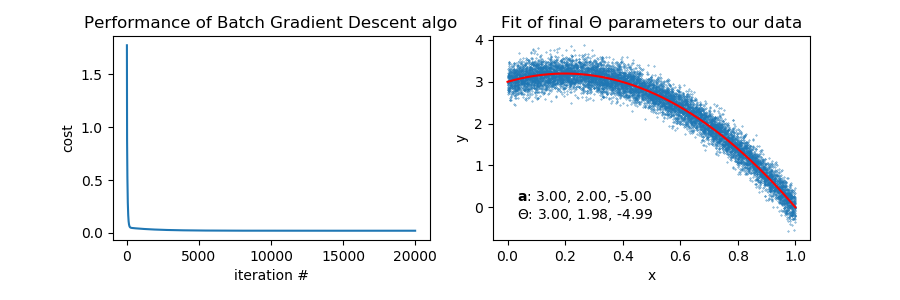

In [33]:
plot_performance_and_final_fit(x, y, X, a_lst, opt_theta, cost_rec, "Batch")

## Stochastic Gradient Descent

In [34]:
def stochastic_gd(X, y, theta=list(np.random.rand(1, X.shape[1])[0]), alpha=0.01, num_iter=100):
    '''
    Use data from just one observation to optimise theta parameters at each iteration
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of initially proposed parameter values. These are updated in this function
    :param alpha: float of the learning rate - determines how big our 'steps' are
    :param num_iter: int stating the number of steps we want to take to optimise our theta parameters
    
    :return theta: (f+1) dimensional list of the final, optimised theta parameters
    :return c: float our final cost corresponding to the our optimised theta parameters
    :return cost_record: (num_iter+1, ) ndarray containing record of MSE cost at each iteration (+ init value)
    :return theta_record: (num_iter+1, f+1) ndarray containing record of theta parameters at each iteration (+ init values)
    '''
    
    # number of observations made
    m = len(y)
    
    # initiate ndarrays that will be contain a record of how our theta and cost values changed with each iteration
    cost_record = np.empty(num_iter+1)
    theta_record = np.empty((num_iter+1, len(theta)))
    
    theta_record[0, :] = theta
    cost_record[0] = cost(X, y, theta)
    
    # update our theta values with each iteration to minimise our cost function
    for i in range(1, num_iter+1):
        
        # randomly select an observation
        rand_idx = np.random.randint(m)
        X_i, y_i = X[rand_idx], y[rand_idx]
        
        # our hypothesis i.e. our guess at what ys we would obtain given features X and parameters theta
        h = X_i.dot(theta)
        
        # calculate new theta values that reduce our total cost and add these to our record
        theta = theta - (alpha * cost_grad(X_i, np.array([y_i]), theta))
        theta_record[i, :] = theta.T
        
        # calculate the MSE cost given the updated theta
        c = cost(X_i, np.array([y_i]), theta)
        cost_record[i] = c
        
    return theta, c, cost_record, theta_record

##### Test our stochastic gradient descent algo and plot its performance and final fit to the data

In [35]:
%%time

# optimise theta parameters
X = X_for_gd(x, x2)
opt_theta, final_cost, cost_rec, theta_rec = stochastic_gd(X, y, alpha=0.1, num_iter=20000)

Wall time: 802 ms


<IPython.core.display.Javascript object>


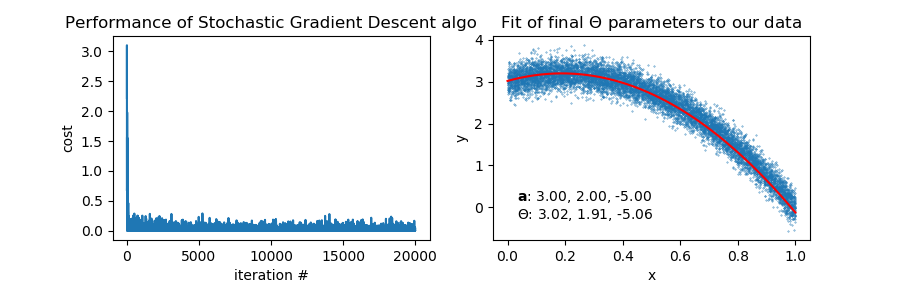

In [36]:
plot_performance_and_final_fit(x, y, X, a_lst, opt_theta, cost_rec, "Stochastic")

## Mini-batch Gradient Descent

Note that 'number of iterations' in this function is a bit different to our earlier definitions. Our Batch and Stochastic functions each took an iteration to be the number of times theta is updated. The mini-batch function in contrast takes it to be the number of times we loop through our entire set of observations, but we will actually update our theta parameters and cost function every time a batch is run. To allow closer comparison to the previous methods, I therefore provide two different 'cost records', one more comprehensive than the other.

Looking online, you will see both methods used for measuring the number of iterations performed. Ultimately, they convey a similar message, but it is worth noting nonetheless.

In [64]:
def minibatch_gd(X, y, theta=list(np.random.rand(1, X.shape[1])[0]), alpha=0.01, num_iter=100, batch_size=20):
    '''
    Use data from a subset of observations to optimise theta parameters at each iteration
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of initially proposed parameter values. These are updated in this function
    :param alpha: float of the learning rate - determines how big our 'steps' are
    :param num_iter: int stating the number of steps we want to take to optimise our theta parameters
    :param batch_size: int stating the number of observations we will include in each update of theta
    
    :return theta: (f+1) dimensional list of the final, optimised theta parameters
    :return c: float our final cost corresponding to the our optimised theta parameters
    :return cost_record: (num_iter+1, ) ndarray containing record of MSE cost at each iteration (+ init value)
    :return theta_record: (num_iter+1, f+1) ndarray containing record of theta parameters at each iteration (+ init values)
    '''
    
    # number of observations made
    m = len(y)
    
    # initiate ndarrays that will be contain a record of how our theta and cost values changed with each iteration
    cost_record = np.empty(num_iter+1)
    theta_record = np.empty((num_iter+1, len(theta)))
    
    update_count = 0
    num_updates = num_iter * math.ceil(m/batch_size)
    cost_record_comprehensive = np.empty(num_updates+1)
    
    theta_record[0, :] = theta
    cost_record[0] = cost(X, y, theta)
    cost_record_comprehensive[0] = cost(X, y, theta)
    
    # update our theta values with each iteration to minimise our cost function
    for i in range(1, num_iter+1):
        
        # randomly shuffle our observations
        rand_idxs = np.random.permutation(m)       
        X_shuffled = X[rand_idxs]
        y_shuffled = y[rand_idxs]
        
        for batch_start in range(0, m, batch_size):
            
            batch_end = batch_start + batch_size
            
            # get subset of X and y obersations
            X_batch = X_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]
            
            # our hypothesis i.e. our guess at what ys we would obtain given features X and parameters theta
            h = X_batch.dot(theta)

            # calculate new theta values that reduce our total cost and add these to our record
            theta = theta - (alpha * cost_grad(X_batch, y_batch, theta))
            theta_record[i, :] = theta.T

            # calculate the MSE cost given the updated theta
            c = cost(X_batch, y_batch, theta)
            
            update_count+=1
            cost_record_comprehensive[update_count] = c
            
        cost_record[i] = c
    
    return theta, c, cost_record, theta_record, num_updates, cost_record_comprehensive

##### Test our mini-batch gradient descent algo and plot its performance and final fit to the data

In [65]:
%%time

# optimise theta parameters
X = X_for_gd(x, x2)
opt_theta, final_cost, cost_rec, theta_rec, num_updates, cost_rec_comp = minibatch_gd(X, y, alpha=0.1, num_iter=10)

Wall time: 133 ms


##### Define 'iteration' to be total number of updates performed

<IPython.core.display.Javascript object>


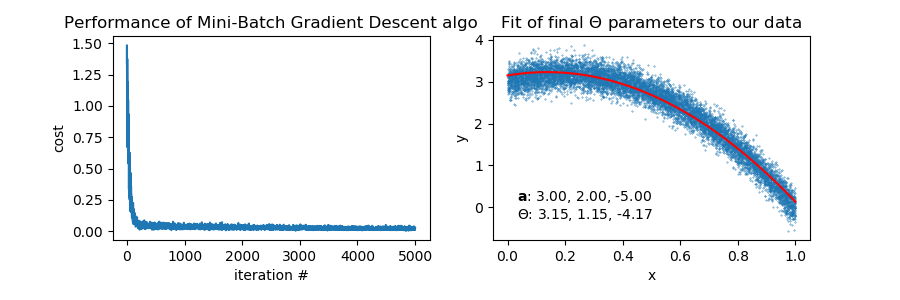

In [70]:
plot_performance_and_final_fit(x, y, X, a_lst, opt_theta, cost_rec_comp, "Mini-Batch")

##### Define 'iteration' to be total number of times we process the entire dataset

<IPython.core.display.Javascript object>


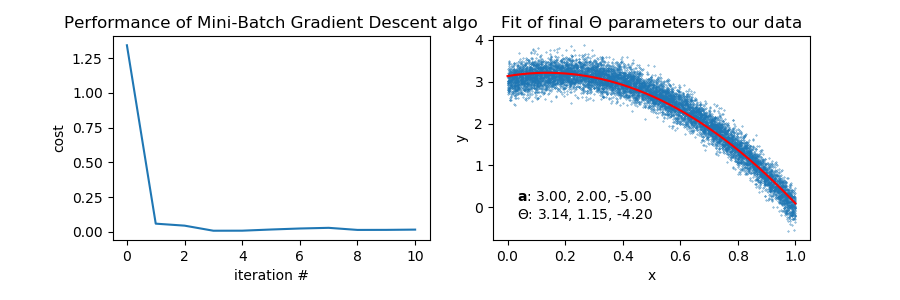

In [45]:
plot_performance_and_final_fit(x, y, X, a_lst, opt_theta, cost_rec, "Mini-Batch")